In [1]:
import os
import csv

#os.chdir(r'C:\My\x2\180617\_merge')
mypath = os.getcwd()
print(mypath)

D:\_PlayGround\Github\pg\_chaos


In [2]:
infile_name = '20180617.csv'
infile_name = '180617_19-50-00.327.csv'

In [3]:
with open(infile_name, encoding='utf8') as csvf:
    rd = csv.reader(csvf, delimiter=',')
    for idx, line in enumerate(rd):
        print(line)
        
        if idx > 10:
            break


['0', '2018-06-17 195000.327002', '0.060999', '2.448898', '2.550633', '2.465567', '100', '1']
['1', '2018-06-17 195000.327004', '0.060352', '2.448898', '2.549986', '2.46589', '100', '1']
['2', '2018-06-17 195000.327006', '0.059705', '2.448898', '2.549016', '2.46589', '100', '1']
['3', '2018-06-17 195000.327008', '0.059058', '2.448898', '2.547723', '2.466536', '100', '1']
['4', '2018-06-17 195000.327010', '0.058411', '2.449222', '2.548369', '2.467829', '100', '1']
['5', '2018-06-17 195000.327012', '0.057441', '2.449222', '2.548046', '2.468152', '100', '1']
['6', '2018-06-17 195000.327014', '0.057441', '2.449545', '2.547723', '2.468798', '100', '1']
['7', '2018-06-17 195000.327016', '0.056793', '2.449545', '2.547723', '2.469122', '100', '1']
['8', '2018-06-17 195000.327018', '0.056146', '2.450839', '2.547399', '2.469445', '100', '1']
['9', '2018-06-17 195000.327020', '0.055823', '2.45181', '2.547399', '2.469768', '100', '1']
['10', '2018-06-17 195000.327022', '0.054852', '2.452781', '2.5

In [4]:
import pandas as pd
import numpy as np

names = ['idx', 'reg_date', 'gold', 'silver_u', 'silver_v', 'silver_w', 'hz', 'ch']
df = pd.read_csv(infile_name, sep=',', names=names)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

max_row = 7000

X = df[['silver_u', 'silver_w', 'silver_v']] .values.reshape(-1,3)[0:max_row, :]
y = df['gold'][0:max_row] / 5 * 1000

poly = PolynomialFeatures(degree=10)
X_poly_reg = poly.fit_transform(X)

model_poly_reg = LinearRegression()
model_poly_reg.fit(X_poly_reg, y)
pred_poly_reg = model_poly_reg.predict(X_poly_reg)

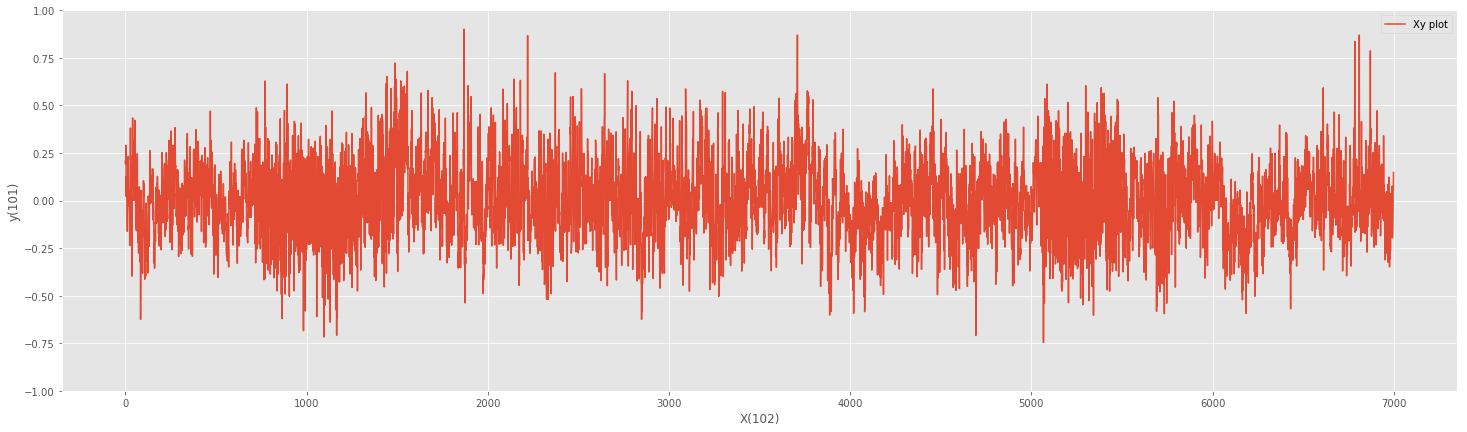

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (25,7)
plt.ylim(ymax=1, ymin=-1)
plt_x = range(len(X[:, 0]))
plt.plot(df['idx'][0:max_row].values, (y - pred_poly_reg), label='Xy plot')
plt.xlabel('X(102)')
plt.ylabel('y(101)')
plt.legend()
plt.show()

In [19]:
pred_poly_reg[0:10]

array([0.01198573, 0.01188035, 0.01173324, 0.01153726, 0.01155324,
       0.01149768, 0.01138563, 0.0113451 , 0.01118822, 0.0110826 ])

In [21]:
np.max(y)

NameError: name 'np' is not defined

In [10]:
import imports85

In [ ]:
# https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/examples/get_started/regression/custom_regression.py

# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Regression using the DNNRegressor Estimator."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import imports85  # pylint: disable=g-bad-import-order

STEPS = 1000
PRICE_NORM_FACTOR = 1000


def my_dnn_regression_fn(features, labels, mode, params):
    """A model function implementing DNN regression for a custom Estimator."""

    # Extract the input into a dense layer, according to the feature_columns.
    top = tf.feature_column.input_layer(features, params["feature_columns"])

    # Iterate over the "hidden_units" list of layer sizes, default is [20].
    for units in params.get("hidden_units", [20]):
        # Add a hidden layer, densely connected on top of the previous layer.
        top = tf.layers.dense(inputs=top, units=units, activation=tf.nn.relu)

    # Connect a linear output layer on top.
    output_layer = tf.layers.dense(inputs=top, units=1)

    # Reshape the output layer to a 1-dim Tensor to return predictions
    predictions = tf.squeeze(output_layer, 1)

    if mode == tf.estimator.ModeKeys.PREDICT:
        # In `PREDICT` mode we only need to return predictions.
        return tf.estimator.EstimatorSpec(
            mode=mode, predictions={"price": predictions})

    # Calculate loss using mean squared error
    average_loss = tf.losses.mean_squared_error(labels, predictions)

    # Pre-made estimators use the total_loss instead of the average,
    # so report total_loss for compatibility.
    batch_size = tf.shape(labels)[0]
    total_loss = tf.to_float(batch_size) * average_loss

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = params.get("optimizer", tf.train.AdamOptimizer)
        optimizer = optimizer(params.get("learning_rate", None))
        train_op = optimizer.minimize(
            loss=average_loss, global_step=tf.train.get_global_step())

        return tf.estimator.EstimatorSpec(
            mode=mode, loss=total_loss, train_op=train_op)

    # In evaluation mode we will calculate evaluation metrics.
    assert mode == tf.estimator.ModeKeys.EVAL

    # Calculate root mean squared error
    rmse = tf.metrics.root_mean_squared_error(labels, predictions)

    # Add the rmse to the collection of evaluation metrics.
    eval_metrics = {"rmse": rmse}

    return tf.estimator.EstimatorSpec(
      mode=mode,
      # Report sum of error for compatibility with pre-made estimators
      loss=total_loss,
      eval_metric_ops=eval_metrics)

In [12]:
def main(argv):
    """Builds, trains, and evaluates the model."""
    # assert len(argv) == 1
    (train, test) = imports85.dataset()

    # Switch the labels to units of thousands for better convergence.
    def normalize_price(features, labels):
        return features, labels / PRICE_NORM_FACTOR

    train = train.map(normalize_price)
    test = test.map(normalize_price)

    # Build the training input_fn.
    def input_train():
        return (
            # Shuffling with a buffer larger than the data set ensures
            # that the examples are well mixed.
            train.shuffle(1000).batch(128)
            # Repeat forever
            .repeat().make_one_shot_iterator().get_next())

    # Build the validation input_fn.
    def input_test():
        return (test.shuffle(1000).batch(128)
                .make_one_shot_iterator().get_next())

    # The first way assigns a unique weight to each category. To do this you must
    # specify the category's vocabulary (values outside this specification will
    # receive a weight of zero). Here we specify the vocabulary using a list of
    # options. The vocabulary can also be specified with a vocabulary file (using
    # `categorical_column_with_vocabulary_file`). For features covering a
    # range of positive integers use `categorical_column_with_identity`.
    body_style_vocab = ["hardtop", "wagon", "sedan", "hatchback", "convertible"]
    body_style = tf.feature_column.categorical_column_with_vocabulary_list(
      key="body-style", vocabulary_list=body_style_vocab)
    make = tf.feature_column.categorical_column_with_hash_bucket(
      key="make", hash_bucket_size=50)

    feature_columns = [
      tf.feature_column.numeric_column(key="curb-weight"),
      tf.feature_column.numeric_column(key="highway-mpg"),
      # Since this is a DNN model, convert categorical columns from sparse
      # to dense.
      # Wrap them in an `indicator_column` to create a
      # one-hot vector from the input.
      tf.feature_column.indicator_column(body_style),
      # Or use an `embedding_column` to create a trainable vector for each
      # index.
      tf.feature_column.embedding_column(make, dimension=3),
    ]

    # Build a custom Estimator, using the model_fn.
    # `params` is passed through to the `model_fn`.
    model = tf.estimator.Estimator(
      model_fn=my_dnn_regression_fn,
      params={
          "feature_columns": feature_columns,
          "learning_rate": 0.001,
          "optimizer": tf.train.AdamOptimizer,
          "hidden_units": [20, 20]
      })

    # Train the model.
    model.train(input_fn=input_train, steps=STEPS)

    # Evaluate how the model performs on data it has not yet seen.
    eval_result = model.evaluate(input_fn=input_test)

    # Print the Root Mean Square Error (RMSE).
    print("\n" + 80 * "*")
    print("\nRMS error for the test set: ${:.0f}"
        .format(PRICE_NORM_FACTOR * eval_result["rmse"]))

    print()

In [13]:
if __name__ == "__main__":
    # The Estimator periodically generates "INFO" logs; make these logs visible.
    tf.logging.set_verbosity(tf.logging.INFO)
    tf.app.run(main=main)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\dongwan.kim\\AppData\\Local\\Temp\\tmpbdj37cks', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002096DCEBF60>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\dongwan.kim\AppData\Local\Temp\tmpbdj37cks\model.ckpt.
INFO:tensorflow:loss = 1.04964e+06, step = 1
INFO:tensorflow:global_step/sec: 136.069
INFO:tensorflow:loss = 1274.98, step = 101 (0.737 sec)
INFO:tensorflow:global_step/sec: 139.105
INFO:tensorflow:loss = 1172.8, step = 20

SystemExit: 

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


###### test

In [ ]:
"""Builds, trains, and evaluates the model."""
# assert len(argv) == 1
(train, test) = imports85.dataset()

# Switch the labels to units of thousands for better convergence.
def normalize_price(features, labels):
    return features, labels / PRICE_NORM_FACTOR

train = train.map(normalize_price)
test = test.map(normalize_price)

# Build the training input_fn.
def input_train():
    return (
        # Shuffling with a buffer larger than the data set ensures
        # that the examples are well mixed.
        train.shuffle(1000).batch(128)
        # Repeat forever
        .repeat().make_one_shot_iterator().get_next())

# Build the validation input_fn.
def input_test():
    return (test.shuffle(1000).batch(128)
            .make_one_shot_iterator().get_next())

# The first way assigns a unique weight to each category. To do this you must
# specify the category's vocabulary (values outside this specification will
# receive a weight of zero). Here we specify the vocabulary using a list of
# options. The vocabulary can also be specified with a vocabulary file (using
# `categorical_column_with_vocabulary_file`). For features covering a
# range of positive integers use `categorical_column_with_identity`.
body_style_vocab = ["hardtop", "wagon", "sedan", "hatchback", "convertible"]
body_style = tf.feature_column.categorical_column_with_vocabulary_list(
  key="body-style", vocabulary_list=body_style_vocab)
make = tf.feature_column.categorical_column_with_hash_bucket(
  key="make", hash_bucket_size=50)

feature_columns = [
  tf.feature_column.numeric_column(key="curb-weight"),
  tf.feature_column.numeric_column(key="highway-mpg"),
  # Since this is a DNN model, convert categorical columns from sparse
  # to dense.
  # Wrap them in an `indicator_column` to create a
  # one-hot vector from the input.
  tf.feature_column.indicator_column(body_style),
  # Or use an `embedding_column` to create a trainable vector for each
  # index.
  tf.feature_column.embedding_column(make, dimension=3),
]

# Build a custom Estimator, using the model_fn.
# `params` is passed through to the `model_fn`.
model = tf.estimator.Estimator(
  model_fn=my_dnn_regression_fn,
  params={
      "feature_columns": feature_columns,
      "learning_rate": 0.001,
      "optimizer": tf.train.AdamOptimizer,
      "hidden_units": [20, 20]
  })

# Train the model.
model.train(input_fn=input_train, steps=STEPS)

# Evaluate how the model performs on data it has not yet seen.
eval_result = model.evaluate(input_fn=input_test)

# Print the Root Mean Square Error (RMSE).
print("\n" + 80 * "*")
print("\nRMS error for the test set: ${:.0f}"
    .format(PRICE_NORM_FACTOR * eval_result["rmse"]))

print()

In [6]:
main(argv='123')

AssertionError: 